In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# It's a hacky temporary code.
import sys

project_root = "."

if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Чтение данных сцены

Задача соревнования - генерация изображений с камер автомобиля по структурированному описанию сцены и изображению с одной из камер. Структурированная информация в виде детекций, карты и параметров камер позволяет понять окружающую обстановку и расположение объектов относительно автомобиля.

Система координат - правая, продольная ось X направлена вперёд, ось Y - влево, ось Z - вверх. Автомобиль расположен в начале координат, его продольная ось X направлена вперёд.

Сцена включает в себя:
- RideId - уникальный идентификатор сцены. Включает в себя имя автомобиля, дату и время съёмки и таймстемп сцены.
- Изображения с камер. Пути до изображений хранятся в словаре image_paths, ключами которого являются названия камер.
- CameraParams - внутренние (pinhole intrinsics) и внешние (extrinsics) параметры камер.
- BBoxesData - 3D-боксы объектов (машины, пешеходы и др.) с координатами 8 углов, классом объекта и флагом видимости для каждой камеры.
- MapData - карта местности с центральными линиями полос, пешеходными переходами и светофорами.
  - Каждая полоса представлена центральной линией, состоящей из линейных 6 сегментов и дополнительных аттрибутов.
  - Каждый пешеходный переход состоит из 8 линейных сегментов.
  - Каждый светофор имеет координаты, направление, тип и дополнительные признаки, описывающие его вид и состояние.



In [ ]:
import pathlib
DATA_ROOT = pathlib.Path("!!!")

scenes = [p.name for p in DATA_ROOT.iterdir() if (p / "ride_id.json").exists()]

print(f"Found {len(scenes)} scenes")

Found 10 scenes


In [9]:
from src.data.types import Scene

scene = Scene.from_path(DATA_ROOT / scenes[1])

print(f"Scene ride_id: {scene.ride_id}")
print(f"Number of cameras: {len(scene.camera_names)}")
print(f"Number of bboxes: {len(scene.bboxes.bboxes)}")
print(f"Number of map centerlines: {scene.map_data.centerlines.n_centerlines}")
print(f"Number of map crosswalks: {scene.map_data.crosswalks.n_crosswalks}")
print(f"Number of map traffic lights: {scene.map_data.traffic_lights.n_traffic_lights}")

Scene ride_id: RideID(ride_date='2025-06-06', ride_time='12:00:23', log_time='13:02:07', rover='96b8f576c788b75e', message_ts=1749204719706332293)
Number of cameras: 6
Number of bboxes: 70
Number of map centerlines: 265
Number of map crosswalks: 7
Number of map traffic lights: 11


# Визуализация 3D-боксов на изображении одной из камер

В этой секции мы проектируем 3D-боксы объектов сцены на изображение выбранной камеры автомобиля. Это позволяет визуально оценить точность и полноту детекций в контексте реальной сцены.

In [10]:
def homogeneous_transform(
    points: np.ndarray,  # shape (*B, N, 3), batch dimension is optional
    projection: np.ndarray, # shape (4, 4) or (3, 3)
    pad: bool = True,
) -> np.ndarray:
    points_w = points
    if pad:
        pad_width = [(0, 0)] * points.ndim
        pad_width[-1] = (0, 1)
        points_w = np.pad(points, pad_width, mode="constant", constant_values=1)
    result = points_w @ projection.T
    new_size = result.shape[-1] - 1
    result = result[..., :new_size] / (result[..., -1:] + 1e-6)
    return result


def project_points_to_image(
    points_xyz: np.ndarray,  # shape (N, 3)
    intrinsics: np.ndarray,  # shape (3, 3)
    extrinsics: np.ndarray,  # shape (4, 4)
) -> tuple[np.ndarray, np.ndarray]:
    # We apply homogeneous_transform twice to get depth values "naturally"
    points_camera_frame = homogeneous_transform(points_xyz, extrinsics)
    in_image_coords = homogeneous_transform(points_camera_frame, intrinsics, pad=False)
    depths = points_camera_frame[:, -1]
    return in_image_coords, depths

In [19]:
camera_id = scene.camera_names[1]  # Choose a camera

image = scene.get_image(camera_id)

intrinsics = scene.camera_params.get_intrinsics_matrix(camera_id)
extrinsics = scene.camera_params.get_extrinsics_matrix(camera_id)

# Project 3D bounding boxes to image
points2d, depths = project_points_to_image(scene.bboxes.bboxes_np, intrinsics, extrinsics)

box_visibility = scene.bboxes.per_camera_visibility.get(camera_id)

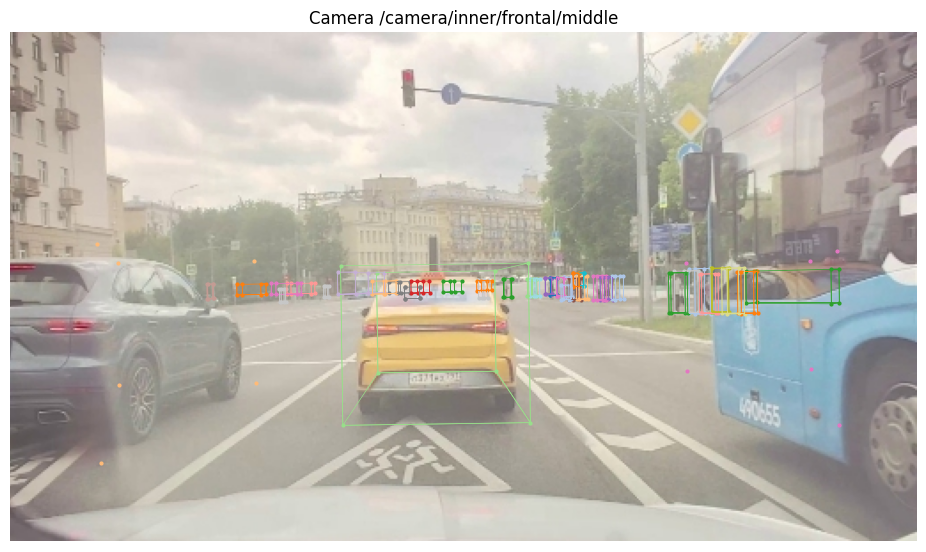

In [20]:
def draw_bbox(
    ax: plt.Axes,
    box2d: np.ndarray,  # shape (8, 2)
    image_h: int,
    image_w: int,
    color=None
):
    BBOX_SIDE_INDICES = [
        (0, 1, 3, 2),  # right
        (4, 5, 7, 6),  # left
        (0, 1, 5, 4),  # top
        (2, 3, 7, 6),  # bottom
        (0, 2, 6, 4),  # front
        (1, 3, 7, 5),  # back
    ]
    is_all_points_inside = np.all(
        (box2d[:, 0] >= 0) & (box2d[:, 0] < image_w) &
        (box2d[:, 1] >= 0) & (box2d[:, 1] < image_h)
    )
    if is_all_points_inside:
        for side in BBOX_SIDE_INDICES:
            xs, ys = box2d[side, 0], box2d[side, 1]
            ax.plot(xs, ys, color=color, linewidth=0.5)
    ax.scatter(box2d[:, 0], box2d[:, 1], s=4, color=color)

figure_width = 10
image_h, image_w = image.shape[0], image.shape[1]

fig, ax = plt.subplots(figsize=(figure_width, figure_width * image_h / image_w))
ax.imshow(image)
for box2d, visible in zip(points2d, box_visibility):
    if visible:
        color = plt.get_cmap("tab20")(np.random.randint(0, 20))
        draw_bbox(ax, box2d, image_h, image_w, color=color)

# Set limits on axes to image size
ax.set_xlim(0, image.shape[1])
ax.set_ylim(image.shape[0], 0)
ax.axis("off")
ax.set_title(f"Camera {camera_id}")

fig.tight_layout()
fig.show()

# Draw map
Нарисуем карту.

In [21]:
def draw_centerlines(ax, centerlines_np):
    """Draw centerlines on the map."""
    for centerline in centerlines_np:
        for segment in centerline:
            x_start, y_start, x_end, y_end = segment[0:4]
            ax.plot([x_start, x_end], [y_start, y_end], color='blue', linewidth=2, alpha=0.7)

def draw_crosswalks(ax, crosswalks_np):
    """Draw crosswalks on the map."""
    for crosswalk in crosswalks_np:
        for segment in crosswalk:
            x_start, y_start, x_end, y_end = segment[0:4]
            ax.plot([x_start, x_end], [y_start, y_end], color='orange', linewidth=2, alpha=0.7)

def draw_traffic_lights(ax: plt.Axes, traffic_lights_np):
    """Draw traffic lights on the map."""
    for tl in traffic_lights_np:
        x, y, z, dx, dy, dz = tl[:6]
        ax.scatter(x, y, color='red', s=60, marker='o')
        ax.arrow(x, y, dx*2, dy*2, color='red', width=0.2, head_width=1.0, length_includes_head=True, alpha=0.7)

def draw_bboxes_bev(ax, bboxes_np):
    """Draw 3D bounding boxes projected onto bird's eye view (x, y) using the bottom face."""
    BOTTOM_FACE_INDICES = (0, 2, 6, 4)
    for box in bboxes_np:
        xs = box[BOTTOM_FACE_INDICES, 0]
        ys = box[BOTTOM_FACE_INDICES, 1]
        ax.add_patch(plt.Polygon(xy=list(zip(xs, ys)), closed=True, fill=None, edgecolor='green', linewidth=1.5, alpha=0.9))

def draw_cameras_bev(ax, camera_params_data):
    """Draw car cameras on the bird's eye view map using extrinsics matrix."""
    for cam_id in camera_params_data.camera_params.keys():
        extrinsics = camera_params_data.get_extrinsics_matrix(cam_id)  # shape (4, 4)
        # extrinsics are world to camera.
        x, y, z = np.linalg.inv(extrinsics)[:3, 3]  # Camera position in world frame

        forward_cam = np.array([0, 2, 0])
        forward_world = -extrinsics[:3, :3] @ forward_cam
        dx, dy = forward_world[0], forward_world[1]
        ax.scatter(x, y, color='purple', s=10, marker='o', label='Camera' if 'Camera' not in ax.get_legend_handles_labels()[1] else None)
        ax.arrow(x, y, dx, dy, color='purple', width=0.05, head_width=0.1, length_includes_head=True, alpha=0.8)
        # ax.text(x, y, cam_id, color='purple', fontsize=8, ha='right', va='bottom')


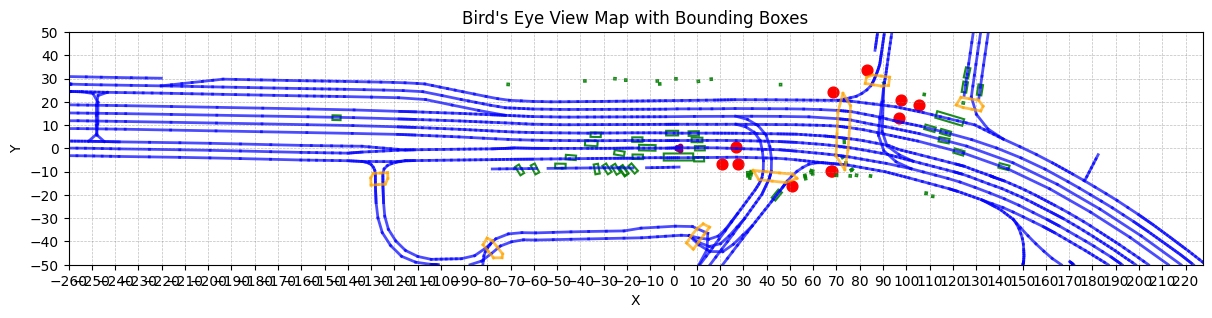

In [22]:
# Collect map elements

centerlines_np = scene.map_data.centerlines_np
crosswalks_np = scene.map_data.crosswalks_np
traffic_lights_np = scene.map_data.traffic_lights_np
bboxes_np = scene.bboxes.bboxes_np

# Limit plot by centerlines extent
min_x = np.min(centerlines_np[:, :, 0])
min_y = np.min(centerlines_np[:, :, 1])
max_x = np.max(centerlines_np[:, :, 2])
max_y = np.max(centerlines_np[:, :, 3])

fig_width = 16
aspect_ratio = (max_y - min_y) / (max_x - min_x)

fig, ax = plt.subplots(figsize=(fig_width, fig_width * aspect_ratio))

draw_centerlines(ax, centerlines_np)
draw_crosswalks(ax, crosswalks_np)
draw_traffic_lights(ax, traffic_lights_np)
draw_bboxes_bev(ax, bboxes_np)
draw_cameras_bev(ax, scene.camera_params)

# Styling
ax.set_aspect('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title("Bird's Eye View Map with Bounding Boxes")
ax.grid(which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
ax.set_xticks(np.arange(-500, 500, 10))
ax.set_yticks(np.arange(-500, 500, 10))
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
ax.grid(True)

fig.tight_layout()
fig.show()